# Importar bibliotecas

In [1]:
# Importar la biblioteca para conectarse a Google Drive.
from google.colab import drive

# Importar PyTorch.
import torchvision
import torch

# Importar la biblioteca "os" para el manejo de archivos.
import os

# Importar la biblioteca "random" para obtener valores aleatorios.
import random

# Importar la biblioteca "PIL" para cargar y manipular imágenes.
from PIL import Image

# Importar la biblioteca "sklearn" para herramientas de aprendizaje automático.
from sklearn.model_selection import train_test_split  # Dividir datos entre entrenamiento y prueba

# Importar la biblioteca "matplotlib" para graficar datos.
from matplotlib import pyplot as plt

# Ajustar la semilla aleatoria de PyTorch para asegurar resultados consistentes.
seed = 42
torch.manual_seed(seed)  # Establece la semilla aleatoria de PyTorch.
torch.cuda.manual_seed_all(seed)  # Establece la semilla aleatoria de PyTorch para la GPU, si está disponible.

# Ajustar PyTorch para usar la GPU si esta disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar datos

In [2]:
# Montar Google Drive en el entorno de Colab para acceder a los datos.
drive.mount('/content/drive')

# Descargar datos
!wget -O '/content/drive/MyDrive/transfer-learning.zip' 'https://deepco-share.s3.amazonaws.com/transfer-learning.zip'
!unzip -q '/content/drive/MyDrive/transfer-learning.zip' -d '/content/drive/MyDrive/'

# Definir una clase personalizada para el conjunto de datos de ropa.
class ClothesDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        # Cargar las listas de imágenes desde las carpetas especificadas.
        self.images = [
            os.listdir(image_dirs[0]),
            os.listdir(image_dirs[1])
        ]

        self.image_dirs = image_dirs
        self.transform = transform

    def __len__(self):
        # Calcular la longitud total del conjunto de datos.
        return sum([len(images_list) for images_list in self.images])

    def __getitem__(self, index):
        # Determinar la clase de la imagen en función del índice y el número de imágenes en la primera carpeta.
        class_name = 0
        if index >= len(self.images[0]):
            index -= len(self.images[0])
            class_name = 1

        # Obtener el nombre de la imagen y su ruta.
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)

        # Abrir la imagen y convertirla a RGB.
        image = Image.open(image_path).convert('RGB')

        # Aplicar transformaciones a la imagen.
        return self.transform(image).to(device), class_name

# Rutas a las carpetas de imágenes.
image_dirs = [
    '/content/drive/MyDrive/transfer-learning/list_1',
    '/content/drive/MyDrive/transfer-learning/list_2'
]

# Definir una secuencia de transformaciones para el conjunto de datos.
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),  # Cambiar el tamaño de la imagen al recomendado para MobileNet V3.
    torchvision.transforms.RandomHorizontalFlip(),  # Aumento de datos: volteo horizontal aleatorio.
    torchvision.transforms.RandomVerticalFlip(),    # Aumento de datos: volteo vertical aleatorio.
    torchvision.transforms.ToTensor()  # Transformar la imagen en un tensor de PyTorch.
])

# Crear el conjunto de datos general con todas las imágenes.
dataset = ClothesDataset(image_dirs, transform)

# Dividir el conjunto de datos en un 80% de datos de entrenamiento y un 20% de datos de prueba.
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=seed)

# Crear cargadores de datos (data loaders) para entrenamiento y prueba.
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2023-10-24 09:24:57--  https://deepco-share.s3.amazonaws.com/transfer-learning.zip
Resolving deepco-share.s3.amazonaws.com (deepco-share.s3.amazonaws.com)... 54.231.232.57, 54.231.199.145, 54.231.233.121, ...
Connecting to deepco-share.s3.amazonaws.com (deepco-share.s3.amazonaws.com)|54.231.232.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1637028 (1.6M) [application/zip]
Saving to: ‘/content/drive/MyDrive/transfer-learning.zip’

/content/drive/MyDr 100%[===================>]   1.56M  --.-KB/s    in 0.1s    

2023-10-24 09:24:57 (11.6 MB/s) - ‘/content/drive/MyDrive/transfer-learning.zip’ saved [1637028/1637028]



# Ver ejemplos de datos disponibles


In [3]:
def show_random_image(images):
    # Seleccionar una imagen al azar del conjunto de datos.
    image, label = random.choice(images)

    # Convertir la imagen a un formato adecuado para mostrarla.
    image = image.cpu().numpy().transpose((1, 2, 0))

    # Mostrar la imagen sin ejes.
    plt.imshow(image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(label)

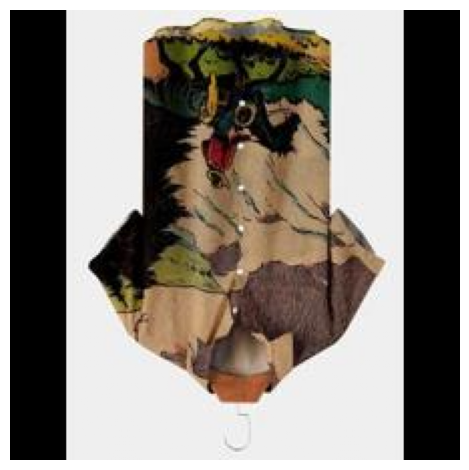

0


In [23]:
# Llamar a la función show_random_image para mostrar una imagen al azar del conjunto de datos de entrenamiento.
show_random_image(train_data)

#Cargar modelo

In [24]:
# Cargar un modelo pre-entrenado de MobileNetV3-Large desde torchvision
clothes_model = torchvision.models.mobilenet_v3_large(weights="MobileNet_V3_Large_Weights.IMAGENET1K_V1")

In [6]:
# Imprime la estructura del modelo MobileNetV3-Large en la consola.
print(clothes_model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

# Modificar y entrenar modelo

In [7]:
# Creamos una nueva capa secuencial que consiste en una capa lineal y la función Hardsigmoid
linear_with_sigmoid = torch.nn.Sequential(
    torch.nn.Linear(1280, 1),  # Capa lineal para transformar la salida a 1 solo valor
    torch.nn.Hardsigmoid()  # Función Hardsigmoid para ajustar la salida entre 0 y 1
)

# Reemplazamos la última capa del modelo original por la nueva capa secuencial
clothes_model.classifier[-1] = linear_with_sigmoid

In [8]:
# Imprime la estructura de nuestro modelo MobileNetV3-Large modificado en la consola.
print(clothes_model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

### Definir las capas que se van a entrenar

In [9]:
# Establecemos que no vamos a entrenar todas las capas del modelo de ropa
clothes_model.train()
clothes_model.requires_grad_(False)

# Pero permitimos que la última capa (la que hemos modificado) sea entrenable
clothes_model.classifier[-1].requires_grad_(True)
clothes_model.to(device)

# Creamos un optimizador Adam para ajustar los parámetros del modelo durante el entrenamiento
optimizer = torch.optim.Adam(clothes_model.parameters(), lr=0.001)

# Utilizamos la función de pérdida Binary Cross Entropy (BCE) para el problema de clasificación binaria
loss_fn = torch.nn.BCELoss()

# Definimos la cantidad de épocas (iteraciones completas del conjunto de datos) para el entrenamiento
epochs = 500

### Ciclo de entrenamiento

In [10]:
# Iteramos a lo largo de un número de épocas predeterminado
for _ in range(epochs):
    # Iteramos a través de los lotes de datos en el conjunto de entrenamiento
    for (images, labels) in train_data_loader:
        # Reiniciamos los gradientes en cada iteración para evitar acumulaciones
        optimizer.zero_grad()

        # Hacemos una predicción utilizando el modelo y aplicamos el método 'squeeze' para eliminar dimensiones innecesarias
        outputs = clothes_model(images).squeeze()

        # Aseguramos que las etiquetas sean de tipo float32 para calcular la pérdida
        labels = labels.to(torch.float32).to(device)

        # Calculamos la pérdida (diferencia entre las predicciones y las etiquetas reales)
        loss = loss_fn(outputs, labels)

        # Realizamos la retropropagación de gradientes para ajustar los parámetros del modelo
        loss.backward()

        # Aplicamos una actualización a los parámetros del modelo utilizando el optimizador
        optimizer.step()


# Validar rendimiento del modelo

In [11]:
accuracy = 0

# Establecemos el modelo en la fase de evaluación, con el objetivo de que sus pesos ya no se modifiquen.
clothes_model.eval()

# Iteramos a través de los datos en el conjunto de prueba
for (images, labels) in (test_data_loader):
    # Realizamos predicciones con el modelo y aplicamos 'squeeze' para eliminar dimensiones innecesarias
    outputs = clothes_model(images).squeeze()

    # Aseguramos que las etiquetas sean de tipo float32 para la comparación
    labels = labels.to(torch.float32).to(device)

    # Calculamos las predicciones finales con un umbral de 0.5 (clase binaria)
    preds = (outputs > 0.5).float()

    # Actualizamos la precisión sumando el número de predicciones correctas
    accuracy += sum((preds == labels).cpu().numpy())

# Calculamos la precisión dividiendo las predicciones correctas por el total de ejemplos en el conjunto de prueba
accuracy = accuracy / len(test_data)
print(f'Precisión del modelo en el conjunto de prueba: {accuracy:.2%}')

Precisión del modelo en el conjunto de prueba: 95.00%


# Guardar modelo en un archivo

In [14]:
#Guardar el modelo en un archivo
torch.save(clothes_model.state_dict(), '/content/drive/MyDrive/transfer-learning/results/model.pth')

# Cargar y utilizar modelo entrenado

In [15]:
# Cargar el modelo y usarlo con una imagen

# Cargar un modelo pre-entrenado MobileNetV3 Large desde torchvision
loaded_model = torchvision.models.mobilenet_v3_large()

# Aplicar las mismas modificaciones que le hicimos en el momento de entrenarlo
# Crear una nueva capa secuencial que consiste en una capa lineal y la función Hardsigmoid
linear_with_sigmoid = torch.nn.Sequential(
    torch.nn.Linear(1280, 1),  # Capa lineal para transformar la salida a 1 solo valor
    torch.nn.Hardsigmoid()  # Función Hardsigmoid para ajustar la salida entre 0 y 1
)

# Reemplazar la última capa del modelo por la nueva capa secuencial
loaded_model.classifier[-1] = linear_with_sigmoid

# Cargar los pesos del modelo entrenado desde un archivo
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/results/model.pth'))

# Establecer el modelo en modo de evaluación
loaded_model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

### Prueba el modelo en tu propia imagen

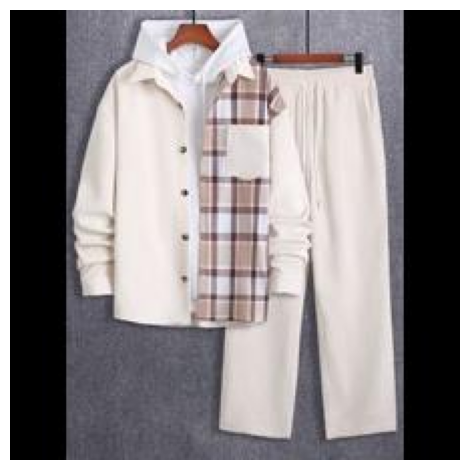

tensor([[False]])


In [17]:
image_path = '/content/drive/MyDrive/transfer-learning/test/test_2.jpg' #Ruta a la imagen que queremos probar

# Definir una secuencia de transformaciones para la imagen de prueba, esta vez sin aumento de datos ya que no es necesario.
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),  # Cambiar el tamaño de la imagen al recomendado para MobileNet V3.
    torchvision.transforms.ToTensor()  # Transformar la imagen en un tensor de PyTorch.
])

# Abrir la imagen desde la ruta especificada, convertirla a RGB y aplicar las transformaciones definidas.
image = Image.open(image_path).convert('RGB')
image = test_transform(image)

# Realizar una predicción con el modelo cargado. Se utiliza `image.unsqueeze(0)` para agregar una dimensión adicional.
# Esto es necesario ya que el modelo espera un lote de imágenes, incluso si solo estamos pasando una imagen.
pred = loaded_model(image.unsqueeze(0))

# Mostrar la imagen y su predicción.
show_random_image([(image, pred > 0.5),])